# Imports

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import nnpde.functions.iterative_methods as im
from nnpde.functions import geometries, helpers
from nnpde.utils.logs import enable_logging, logging 
from nnpde.problems import DirichletProblem 
from nnpde.utils import plots

In [3]:
enable_logging(10)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

2018-12-18 14:32:28,296 - root - INFO - logs - logging enabled for level: 10


# Setup

In [4]:
# Define train dimension
N = 16

# Initialize f: we use a zero forcing term for training
f = torch.zeros(1, 1, N, N)

# For each problem instance define number of iteration to perform to obtain the solution
nb_problem_instances = 30
problem_instances = [DirichletProblem(k=k) for k in np.random.randint(1, 20, nb_problem_instances)]

In [5]:
B_idx = problem_instances[1].B_idx

In [6]:
net = nn.Sequential(nn.Conv2d(1, 1, 3, padding=1, bias=False))
G = helpers.build_G(B_idx)
T = helpers.build_T(N)
H = helpers.conv_net_to_matrix(net, N)
I = np.eye(N)

In [7]:
helpers.spectral_radius(T+G.dot(H).dot(T)-G.dot(H))

1.068310480424216

# Train using the class

2018-12-18 14:33:57,910 - root - INFO - model - iter 0 with total loss 1351.6844482421875
2018-12-18 14:34:16,837 - root - INFO - model - iter 100 with total loss 575.4085693359375
2018-12-18 14:34:34,760 - root - INFO - model - iter 200 with total loss 91.37628173828125
2018-12-18 14:34:55,504 - root - INFO - model - iter 300 with total loss 28.220571517944336
2018-12-18 14:35:10,802 - root - INFO - model - iter 400 with total loss 26.332304000854492
2018-12-18 14:35:25,809 - root - INFO - model - iter 500 with total loss 25.655384063720703
2018-12-18 14:35:41,262 - root - INFO - model - iter 600 with total loss 25.18518829345703
2018-12-18 14:35:57,443 - root - INFO - model - iter 700 with total loss 25.23937225341797
2018-12-18 14:36:13,649 - root - INFO - model - iter 800 with total loss 24.86842155456543
2018-12-18 14:36:29,990 - root - INFO - model - iter 900 with total loss 24.888568878173828


final loss is 24.792564392089844
final loss is 24.792564392089844


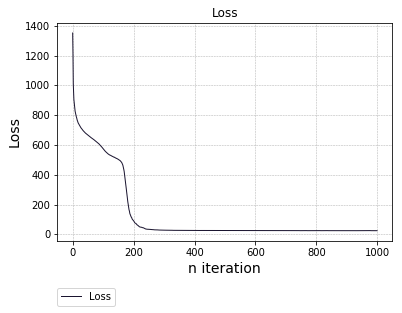

In [13]:
import nnpde.model as M 
reload(M)

# TODO fit would idealy take X, y, (u_0 and u_*)
model = M.JacobyWithConv(max_iters=1000, batch_size=10, learning_rate = 1e-6, nb_layers=3).fit(problem_instances)
losses = model.losses
plots.plot_loss(losses)

print("final loss is {0}".format(losses[-1]))

# Test on a bigger grid

In [11]:
from nnpde.metrics import least_squares_loss as LSE

In [14]:
N = 50
nb_iters = 2000

B_idx, B = geometries.square_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(model.net, B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)
jacoby_pure = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)

print(f"error after {nb_iters} for both methods: {LSE(output, jacoby_pure)}, and ground truth and jacoby {LSE(gtt, jacoby_pure)}")

error after 2000 for both methods: 99473.75, and ground truth and jacoby 99349.3515625


In [16]:
loss_to_be_achieved = 1e-3

u_0 = torch.ones(1, 1, N, N)
net = model.net

In [18]:
%%timeit

u_k_old = im.jacobi_method(B_idx, B, f, u_0, k = 1)
loss_of_old = LSE(gtt, u_k_old)
k_count_old = 1
count_old = 1
# old method 
while loss_of_old >= loss_to_be_achieved:
    u_k_old = im.jacobi_method(B_idx, B, f, u_k_old, k = 1)
    loss_of_old = LSE(gtt, u_k_old)
    k_count_old += 1
    
print(k_count_old)

5583
5583
5583
5583
5583
5583
5583
5583
1.14 s ± 87.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit

u_k_new = im.H_method(net, B_idx, B, f, u_0, k=1)

loss_new = LSE(gtt, u_k_new)
k_count_new = 1


# new method

while loss_new >= loss_to_be_achieved:
    u_k_new = im.H_method(net, B_idx, B, f, u_k_new, k=1)
    loss_new = LSE(gtt, u_k_new)
    k_count_new += 1
    
print(k_count_new)

323
323
323
323
323
323
323
323
122 ms ± 9.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# This is not correct, but we have to look for a way to access the variables inside timeit

print("needed {0} iterations (compared to {1}), ratio: {2}".format(k_count_old, k_count_new, k_count_old/k_count_new))

In [ ]:
print("the loss of the new method is {0}, compared to the pure-jacoby one: {1}. computed with {2} iterations".format(F.mse_loss(gtt, output), F.mse_loss(gtt, jacoby_pure), nb_iters))

In [ ]:
helpers.plot_solution(gtt,output,N)

In [ ]:
(gtt.view(N,N) - output.view(N,N)).mean()

Test on L-shape domain

In [ ]:
B_idx, B = geometries.l_shaped_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 2000)

In [ ]:
helpers.plot_solution(gtt,output,N)

In [ ]:
multiply_adds = 1

def count_conv2d(shapex, shapey,in_channels = 1,out_channels = 1,kernel_size = (3,3)):
    
    cin = in_channels
    cout = out_channels
    kh, kw = kernel_size
    batch_size = shapex[0]

    out_w = shapey[2]
    out_h = shapey[3]

    # ops per output element
    # kernel_mul = kh * kw * cin
    # kernel_add = kh * kw * cin - 1
    
    kernel_ops = multiply_adds * kh * kw * cin
    ops_per_element = kernel_ops

    # total ops
    # num_out_elements = y.numel()
    output_elements = batch_size * out_w * out_h * cout
    total_ops = output_elements * ops_per_element

    # in case same conv is used multiple times
    total_ops += torch.Tensor([int(total_ops)])
    
    return total_ops

In [ ]:
def compare_flops(n,n_iter_conv,n_iter_jac,layers):
    #flops, params = profile(net, input_size=input_shape)
    flop_conv = (count_conv2d((1,1,256,256),(1,1,3,3)) + 2*n**2 + 4) * n_iter_conv # 9 operations for each convolution, and we perform n^2 convolutions in total for each layer + 6 operations for the jacobi iteration step
    flop_jac = (7 * n**2) * n_iter_jac # For each u_ij, we add its 4 neighbors + forcing term + resetting the boundaries
    return flop_conv/flop_jac

In [ ]:
compare_flops(16,k_count_new,k_count_old,3)